In this notebook we take the approach of randomly undersampling the majority class (0 i.e. happy) to create balanced training data sets.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [29]:
# We import custom utility functions for data processing and random forest training
from process_data import process, create_submission
from train_forests import *

In [3]:
data = pd.read_csv('data/train.csv')

In [4]:
process(data)

In [5]:
def select_features(n_trees, data):
    rf = RandomForestClassifier(n_trees)
    rf.fit(data.ix[:,:-1], data.ix[:,-1])
    fimp = rf.feature_importances_
    important = []
    for idx, name in enumerate(data.ix[:,:-1].columns):
        if fimp[idx] > 0.1:
            important.append(name)
    return important

In [6]:
# We can use an initial random forest to select important features
if False:
    selected = select_features(1000, data)
    selected+= ["TARGET"]
    data = data[selected]
    len(selected)

The performace is similar wether we take 3 features or 300...

In [7]:
submission = False

In [8]:
if submission:
    train = data 
else:
    train, test = train_test_split(data, test_size = 0.2, random_state = 42)

According to the cross-validation analysis, the best results are obtained with N=4, w=1, N_forest=60, n_trees=300

In [9]:
a = 0.25 # a can also be >1 to also oversample the minority class (1 ie. unhappy)
w = 1
N_forest = 60
n_trees = 300

In [10]:
rfs = trainForests(train, a, w, N_forest,n_trees)

In [11]:
X_test, Y_test = test.ix[:,:-1], test.ix[:,-1]

In [12]:
Y_prob = mean_ensemble(rfs, X_test)

In [13]:
(roc_auc_score(Y_test,Y_prob) - 0.83)*100

0.49458866262944712

### Score analysis

In [14]:
X_test, Y_test = test.ix[:,:-1], test.ix[:,-1]
n = 100
a = 0.25
w = 1
N_forest = 5
n_trees = 5

In [15]:
scores = []
for _ in range(n):
    rfs = trainForests(train, a, w, N_forest,n_trees)
    Y_prob = mean_ensemble(rfs, X_test)
    scores.append(roc_auc_score(Y_test,Y_prob))
scores = pd.DataFrame(scores)

In [16]:
scores.describe()

,0
count,100.000000
mean,0.814254
std,0.004943
min,0.800231
25%,0.811262
50%,0.814457
75%,0.817243
max,0.828423


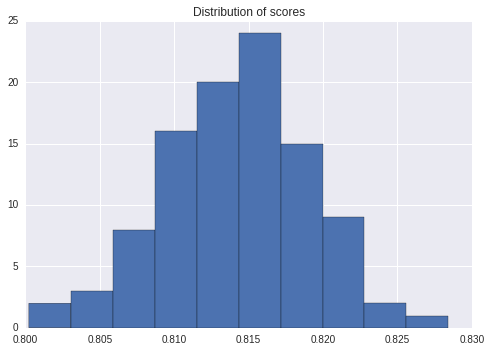

In [17]:
plt.title("Distribution of scores")
plt.hist(scores)
plt.show()

In [18]:
# If desired, transform probabilities into class labels.
def threshold(Y_prob, threshold = 0.5):
    result = []
    for y in Y_prob:
        if y <= threshold:
            result.append(0)
        else:
            result.append(1)
    return result

In [19]:
# Evaluate class labels
Y_pred = threshold(Y_prob, threshold = 0.5)
_ = eval_classification(test['TARGET'],Y_pred, print_results = True)

[[11134  3463]
 [  175   432]]
Misclassification error: 0.239279137069
Recall (Sensitivity): 0.711696869852
Specificity: 0.762759471124
Precision: 0.110911424904
F1-score: 0.191914704576
AUC of sensitivity-specificity: 0.737228170488


In [20]:
# Plot feature importance
def plot_features(forest, n):  
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(n), importances[indices],
           color="r", yerr=std[indices], align="center")
    plt.xticks(range(n), indices)
    plt.xlim([-1, n])
    plt.show()

## Only for submission

In [21]:
test = pd.read_csv('data/test.csv')
test_id = test.ix[:,'ID'].values
process(test)

In [22]:
Y_prob = mean_ensemble(rfs,test)

In [ ]:
create_submission(test_id, Y_prob)